## Diffusion lengthscale

Toy model of 1-D diffusion of a linear concentration profile through two layers with different diffusivities. 

We discretize the 1-D diffusion equation 

$$\frac{\partial C}{\partial t} =  \frac{\partial}{\partial z}\Big(\frac{\kappa\partial C}{\partial z}\Big)$$

using using forward differences for time and the spatial stencil

 o----x----o----x----o    

i-1---ki---i---ki+1--i+1   

Ci-1-------Ci--------Ci+1   


as

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}= \frac{\kappa_i(C_{i}^n-C_{i-1}^n)-\kappa_{i+1}(C_{i+1}^n-C_i^n)}{\Delta z^2}$$

using forward differences for time. Note that when $\kappa_i = \kappa_{i+1}$, we recover the usual central differences scheme for the second derivative:

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}= \frac{\kappa(C_{i+1}^n-2C_{i}^n+C_{i-1}^n)}{\Delta z^2}$$

So, we calculate the concentration at time step n+1 as

$$C_i^{n+1}=\frac{\Delta t}{\Delta z^2}(\kappa_i(C_{i}^n-C_{i-1}^n)-\kappa_{i+1}(C_{i+1}^n-C_i^n)) + C_i^{n}$$.


In [1]:
import cmocean as cmo
import numpy as np  
import matplotlib.gridspec as gspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import seaborn as sns
import scipy.stats

%matplotlib inline

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [3]:
# Plots appearance
sns.set_context('talk')
sns.set_style('whitegrid')

In [4]:
def timesteppingKv(IC, KK, dt, dz, maxt):
    '''Iterate for nt timesteps the solution to the diffusion equation with variable Kv
    INPUT
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    rhok = np.copy(IC)  
    for t in np.arange(dt, maxt, dt):
        newrho = rhok[1:-1] + dt/dz**2 * (KK[0:-1] * rhok[0:-2] - 
                                         (KK[0:-1]+KK[1:])*rhok[1:-1] + 
                                             KK[1:]*rhok[2:])
        rhok[1:-1] = newrho
    return(rhok)

def smoothHS(hdepth, epsilon, Hr, kbg, kcan):
    '''Build smooth Heaviside function at mid-depth points hdepth ''' 
    
    KK = kbg + kcan*(0.5 + 
                     0.5*(hdepth-Hr)/epsilon + 
                     1./(2*np.pi)*np.sin(np.pi*(hdepth-Hr)/(epsilon)))
    KK[hdepth < Hr - epsilon] = kbg
    KK[hdepth >= Hr + epsilon] = kbg + kcan
    return KK

In [5]:
# INITIALIZATION 

sbd = 150.
Hr = 110. # m
td = 2*sbd # total depth
npts = 500
Z = 50
dz = td/npts

N = 0.5e-2*np.ones(npts)
depth = np.arange(0, td, dz)
hdepth = depth[:-1]+dz/2.

# IC
rho = np.zeros((2, npts))
rho[0] = 1010 + N**2*1000/10.*depth
rho[1] = rho[0] + N**2*1000/10.*Z*depth/Hr # uplifted

epsilon = 50.
eindz = int(epsilon/dz)


# Diffusivity
kbg = 1E-5              # background diffusivity
kcan = 1E-3             # canyon diffusivity

# Talk to me
print('The vertical resolution is %1.3f meters' %dz)

The vertical resolution is 0.600 meters


/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc05e927ac8>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


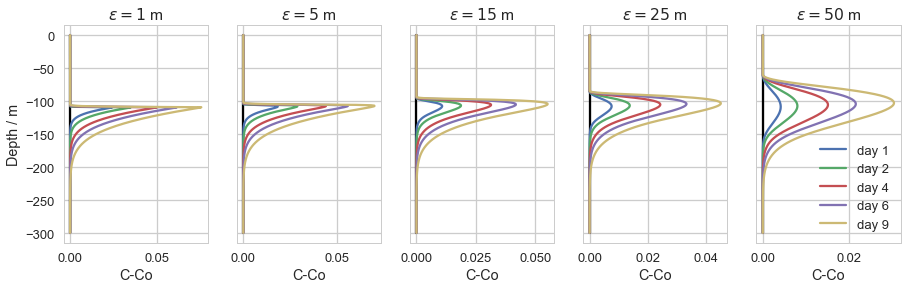

In [6]:
# PLOT RESULTING CONCENTRATION
fig, ax = plt.subplots(1,5, figsize=(15,4), sharey = True)

for axii in ax: 
    l1 = axii.plot(rho[0]-rho[0],-depth,  'k-')

lines = [l1]

times = [1,2,4,6,9]

for time in times:
    dt, maxt = 10, 86400*time/10
              
    conc01 = timesteppingKv(rho[0],smoothHS(hdepth, 1, Hr, 1E-5, 1E-2), dt, dz, maxt)
    conc02 = timesteppingKv(rho[0],smoothHS(hdepth, 5, Hr, 1E-5, 1E-2), dt, dz, maxt)
    conc03 = timesteppingKv(rho[0],smoothHS(hdepth, 15, Hr, 1E-5, 1E-2), dt, dz, maxt)
    conc04 = timesteppingKv(rho[0],smoothHS(hdepth, 25, Hr, 1E-5, 1E-2), dt, dz, maxt)
    conc05 = timesteppingKv(rho[0],smoothHS(hdepth, 50, Hr, 1E-5, 1E-2), dt, dz, maxt)
    
    ax[0].plot(conc01-rho[0],-depth,)
    ax[1].plot(conc02-rho[0],-depth,)
    ax[2].plot(conc03-rho[0],-depth,)
    ax[3].plot(conc04-rho[0],-depth,)
    l2, = ax[4].plot(conc05-rho[0],-depth,)
    
    lines.append(l2)

ax[4].legend((lines), ('IC', 'day 1', 'day 2', 'day 4', 'day 6', 'day 9'), loc=0) 

ax[0].set_title('$\epsilon = 1$ m')
ax[1].set_title('$\epsilon = 5$ m')
ax[2].set_title('$\epsilon = 15$ m')
ax[3].set_title('$\epsilon = 25$ m')
ax[4].set_title('$\epsilon = 50$ m')

ax[0].set_ylabel('Depth / m')

for aa in ax:
    aa.set_xlabel('C-Co')

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/legend.py:938: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x7fc05c864940>] instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  "aka-proxy-artists".format(orig_handle)


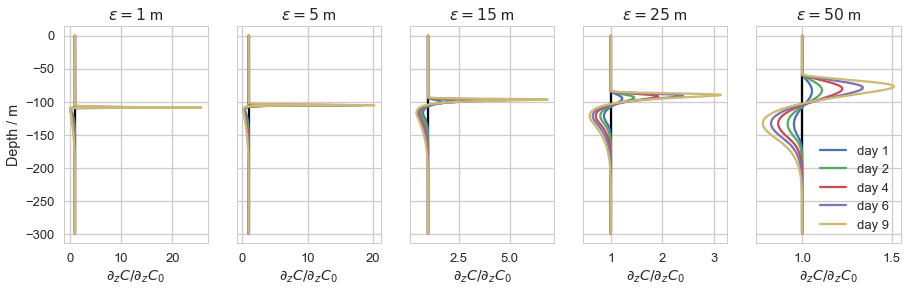

In [7]:
# PLOT RESULTING CONCENTRATION
fig, ax = plt.subplots(1,5, figsize=(15,4), sharey = True)

for axii in ax: 
    dCo = (rho[0,1:]-rho[0,:-1])/dz
    l1 = axii.plot(np.squeeze(dCo/dCo),-depth[:-1]-dz/2,  'k-')
    
lines = [l1]

times = [1,2,4,6,9]

for time in times:
    dt, maxt = 10, 86400*time/10
              
    conc01 = timesteppingKv(rho[0],smoothHS(hdepth, 1, Hr, 1E-5, 1E-2), dt, dz, maxt)
    dC1 = (conc01[1:]-conc01[:-1])/dz
    conc02 = timesteppingKv(rho[0],smoothHS(hdepth, 5, Hr, 1E-5, 1E-2), dt, dz, maxt)
    dC2 = (conc02[1:]-conc02[:-1])/dz
    conc03 = timesteppingKv(rho[0],smoothHS(hdepth, 15, Hr, 1E-5, 1E-2), dt, dz, maxt)
    dC3 = (conc03[1:]-conc03[:-1])/dz
    conc04 = timesteppingKv(rho[0],smoothHS(hdepth, 25, Hr, 1E-5, 1E-2), dt, dz, maxt)
    dC4 = (conc04[1:]-conc04[:-1])/dz
    conc05 = timesteppingKv(rho[0],smoothHS(hdepth, 50, Hr, 1E-5, 1E-2), dt, dz, maxt)
    dC5 = (conc05[1:]-conc05[:-1])/dz
    
    ax[0].plot(dC1/dCo,-depth[:-1]-dz/2)
    ax[1].plot(dC2/dCo,-depth[:-1]-dz/2)
    ax[2].plot(dC3/dCo,-depth[:-1]-dz/2)
    ax[3].plot(dC4/dCo,-depth[:-1]-dz/2)
    l2, = ax[4].plot(dC5/dCo,-depth[:-1]-dz/2)
    
    lines.append(l2)

ax[4].legend((lines), ('IC', 'day 1', 'day 2', 'day 4', 'day 6', 'day 9'), loc=0) 

ax[0].set_title('$\epsilon = 1$ m')
ax[1].set_title('$\epsilon = 5$ m')
ax[2].set_title('$\epsilon = 15$ m')
ax[3].set_title('$\epsilon = 25$ m')
ax[4].set_title('$\epsilon = 50$ m')

ax[0].set_ylabel('Depth / m')

for aa in ax:
    aa.set_xlabel('$\partial_zC/\partial_zC_0$')

### Total flux mismatch

0.00249999999994
2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07


Text(0,0.5,'$\\partial C_0/\\partial z \\sum(K_i-K_{i-1})$')

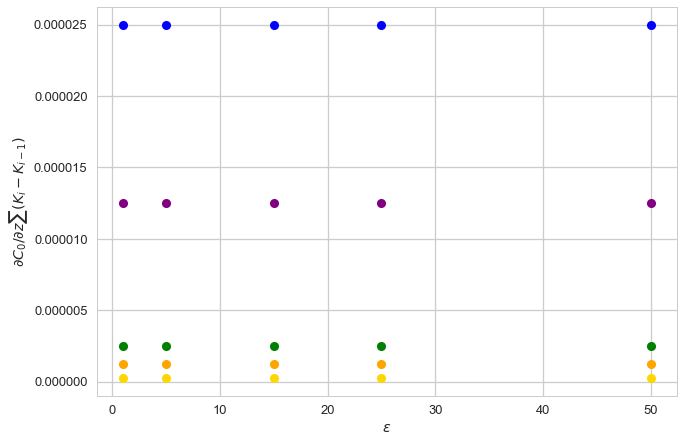

In [8]:
dCdz = dCo[int(npts/2)]
print(dCdz)

colors =['blue', 'purple', 'green', 'orange', 'gold', 'magenta']

for kappa_canyon, col in zip([1E-2, 5E-3, 1E-3, 5E-4, 1E-4],colors):
    for eps in [1,5,15,25,50]:
        KK = smoothHS(hdepth, eps, Hr, kbg, kappa_canyon)
        plt.plot(eps, dCdz*np.sum(KK[1:]-KK[:-1]), 'o', color = col)
        print(dCdz*np.sum(KK[1:]-KK[:-1]))
   
plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\partial C_0/\partial z \sum(K_i-K_{i-1})$')

2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07


Text(0.5,1,'L')

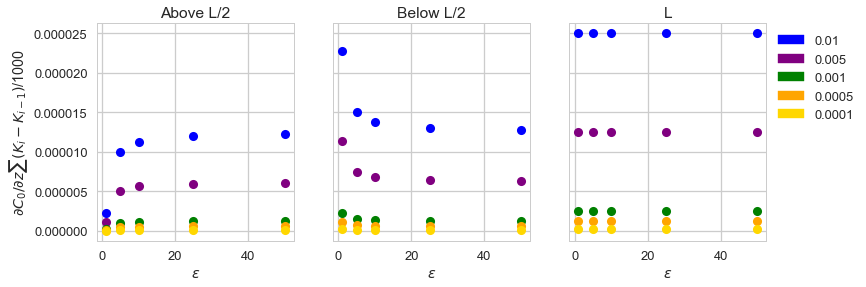

In [9]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
patches = []

for kappa_canyon, col in zip([1E-2, 5E-3, 1E-3, 5E-4, 1E-4],colors):
    for eps in [1,5,10,25,50]:
        KK = smoothHS(hdepth, eps, Hr, kbg, kappa_canyon)
        ax[0].plot(eps, dCdz*np.sum(KK[1:int(Hr/dz)]-KK[:int(Hr/dz)-1]), 'o', color = col)
        ax[1].plot(eps, dCdz*np.sum(KK[int(Hr/dz):]-KK[int(Hr/dz)-1:-1]), 'o', color = col)
        ax[2].plot(eps, dCdz*np.sum(KK[1:]-KK[:-1]), 'o', color = col, label = '$K_{can}$')
        
        print(dCdz*np.sum(KK[1:]-KK[:-1]))
    m_patch = mpatches.Patch(color=col,label=str(kappa_canyon))
    patches.append(m_patch)
    
ax[0].set_xlabel(r'$\epsilon$')
ax[1].set_xlabel(r'$\epsilon$')
ax[2].set_xlabel(r'$\epsilon$')
ax[0].set_ylabel(r'$\partial C_0/\partial z \sum(K_i-K_{i-1})$/1000')

ax[2].legend(handles=patches,bbox_to_anchor=(1,1))

ax[0].set_title(r'Above L/2')
ax[1].set_title(r'Below L/2')
ax[2].set_title(r'L')

2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
2.49999999994e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
1.24999999997e-05
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
2.49999999994e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
1.24999999997e-06
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07
2.49999999994e-07


Text(0.5,1,'Below - Above')

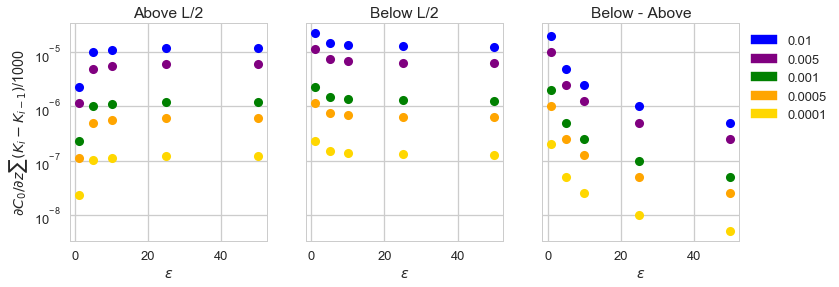

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
patches = []
for kappa_canyon, col in zip([1E-2, 5E-3, 1E-3, 5E-4, 1E-4],colors):
    for eps in [1,5,10,25,50]:
        KK = smoothHS(hdepth, eps, Hr, kbg, kappa_canyon)
        ax[0].plot(eps, dCdz*np.sum(KK[1:int(Hr/dz)]-KK[:int(Hr/dz)-1]), 'o', color = col)
        ax[1].plot(eps, dCdz*np.sum(KK[int(Hr/dz):]-KK[int(Hr/dz)-1:-1]), 'o', color = col)
        ax[2].plot(eps, 
                   dCdz*np.sum(KK[int(Hr/dz):]-KK[int(Hr/dz)-1:-1])-
                   dCdz*np.sum(KK[1:int(Hr/dz)]-KK[:int(Hr/dz)-1]), 
                   'o', color = col, label = '$K_{can}$')
        
        print(dCdz*np.sum(KK[1:]-KK[:-1]))
    m_patch = mpatches.Patch(color=col,label=str(kappa_canyon))
    patches.append(m_patch)
    
ax[0].set_xlabel(r'$\epsilon$')
ax[1].set_xlabel(r'$\epsilon$')
ax[2].set_xlabel(r'$\epsilon$')
ax[0].set_ylabel(r'$\partial C_0/\partial z \sum(K_i-K_{i-1})$/1000')
ax[0].set_yscale("log", nonposy='clip')
ax[1].set_yscale("log", nonposy='clip')
ax[2].set_yscale("log", nonposy='clip')

ax[2].legend(handles=patches,bbox_to_anchor=(1,1))

ax[0].set_title(r'Above L/2')
ax[1].set_title(r'Below L/2')
ax[2].set_title(r'Below - Above')

2.21978499193e-05
67.8450157297
5.92366152668e-06
35.0475456231
2.99039733872e-06
24.9015821218
1.19938434372e-06
15.7703626312
5.99923023543e-07
11.1534765058
1.10989249596e-05
47.9736706922
2.96183076334e-06
24.782357174
1.49519866936e-06
17.6080775806
5.99692171861e-07
11.1513303583
2.99961511772e-07
7.88669887104
2.21978499193e-06
21.4544777596
5.92366152668e-07
11.0830070568
2.99039733872e-07
7.87457168467
1.19938434372e-07
4.98702654414
5.99923023543e-08
3.52703895874
1.10989249596e-06
15.1706067106
2.96183076334e-07
7.83686944577
1.49519866936e-07
5.56816303717
5.99692171861e-08
3.52636028732
2.99961511772e-08
2.49399316524
2.21978499193e-07
6.78450157297
5.92366152668e-08
3.50475456231
2.99039733872e-08
2.49015821218
1.19938434372e-08
1.57703626312
5.99923023543e-09
1.11534765058


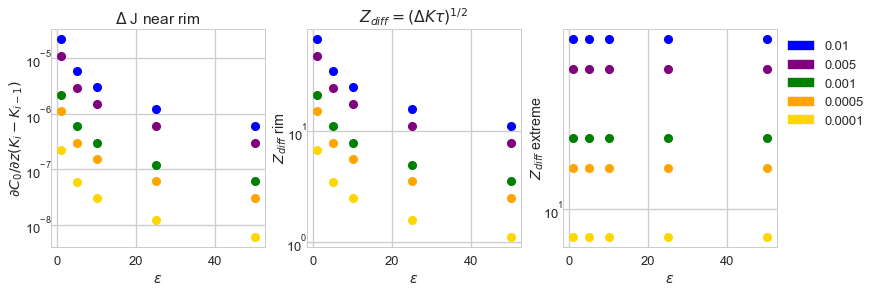

In [11]:
fig, ax = plt.subplots(1,3, figsize=(13,4))
patches = []
for kappa_canyon, col in zip([1E-2, 5E-3, 1E-3, 5E-4, 1E-4],colors):
    for eps in [1,5,10,25,50]:
        KK = smoothHS(hdepth, eps, Hr, kbg, kappa_canyon)
        ax[0].plot(eps, dCdz*(KK[int(Hr/dz)+1]-KK[int(Hr/dz)-1]), 'o', color = col)
        ax[1].plot(eps, ((KK[int(Hr/dz)+1]-KK[int(Hr/dz)-1])*6*3600*24)**0.5, 'o', color = col)
        ax[2].plot(eps, ((KK[int((Hr+eps)/dz)]-KK[int((Hr-eps)/dz)])*6*3600*24)**0.5, 'o', color = col, label = '$K_{can}$')
        
        print(dCdz*(KK[int(Hr/dz)+1]-KK[int(Hr/dz)-1]))
        print(((KK[int(Hr/dz)+1]-KK[int(Hr/dz)-1])*6*3600*24)**0.5)
    m_patch = mpatches.Patch(color=col,label=str(kappa_canyon))
    patches.append(m_patch)
    
ax[0].set_xlabel(r'$\epsilon$')
ax[1].set_xlabel(r'$\epsilon$')
ax[2].set_xlabel(r'$\epsilon$')
ax[0].set_ylabel(r'$\partial C_0/\partial z (K_i-K_{i-1})$', labelpad=0)
ax[1].set_ylabel(r'$Z_{diff}$ rim', labelpad=-3)
ax[2].set_ylabel(r'$Z_{diff}$ extreme', labelpad=-3)

ax[2].legend(handles=patches,bbox_to_anchor=(1,1))

ax[0].set_title(r'$\Delta$ J near rim')
ax[1].set_title(r'$Z_{diff}=(\Delta K \tau)^{1/2}$')
ax[0].set_yscale("log", nonposy='clip')
ax[1].set_yscale("log", nonposy='clip')
ax[2].set_yscale("log", nonposy='clip')
ax[0].tick_params(axis='y', pad=0)
ax[1].tick_params(axis='y', pad=0)
ax[2].tick_params(axis='y', pad=0)


67.8450157297
2.12105922494
35.0475456231
0.514157321875
24.9015821218
0.258667698481
15.7703626312
0.103645897377
11.1534765058
0.0518357365401
47.9736706922
1.06052961247
24.782357174
0.257078660938
17.6080775806
0.129333849241
11.1513303583
0.0518229486885
7.88669887104
0.02591786827
21.4544777596
0.212105922494
11.0830070568
0.0514157321875
7.87457168467
0.0258667698481
4.98702654414
0.0103645897377
3.52703895874
0.00518357365401
15.1706067106
0.106052961247
7.83686944577
0.0257078660938
5.56816303717
0.0129333849241
3.52636028732
0.00518229486885
2.49399316524
0.002591786827
6.78450157297
0.0212105922494
3.50475456231
0.00514157321875
2.49015821218
0.00258667698481
1.57703626312
0.00103645897377
1.11534765058
0.000518357365401


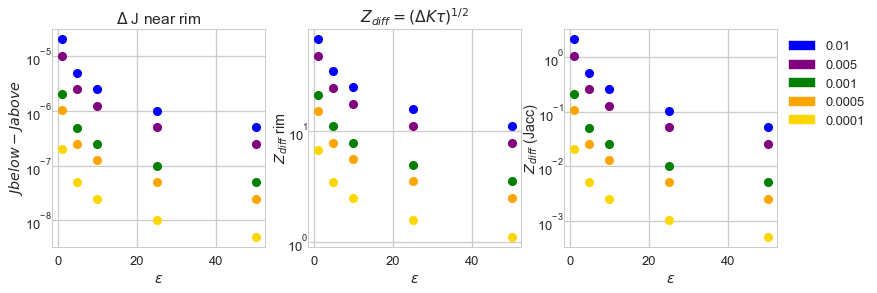

In [12]:
fig, ax = plt.subplots(1,3, figsize=(13,4))
patches = []
dCo = 5

for kappa_canyon, col in zip([1E-2, 5E-3, 1E-3, 5E-4, 1E-4],colors):
    for eps in [1,5,10,25,50]:
        KK = smoothHS(hdepth, eps, Hr, kbg, kappa_canyon)
        Jacc = (dCdz*np.sum(KK[int(Hr/dz):]-KK[int(Hr/dz)-1:-1])-
                dCdz*np.sum(KK[1:int(Hr/dz)]-KK[:int(Hr/dz)-1]))
        
        ax[0].plot(eps, Jacc, 'o', color = col, label = '$K_{can}$')
        ax[1].plot(eps, ((KK[int(Hr/dz)+1]-KK[int(Hr/dz)-1])*6*3600*24)**0.5,
                   'o', color = col)
        ax[2].plot(eps, Jacc*6*3600*24/dCo, 'o', color = col, label = '$K_{can}$')
        
        print(((KK[int(Hr/dz)+1]-KK[int(Hr/dz)-1])*6*3600*24)**0.5)
        print(Jacc*6*3600*24/dCo)
    m_patch = mpatches.Patch(color=col,label=str(kappa_canyon))
    patches.append(m_patch)
    
ax[0].set_xlabel(r'$\epsilon$')
ax[1].set_xlabel(r'$\epsilon$')
ax[2].set_xlabel(r'$\epsilon$')
ax[0].set_ylabel(r'$J below - J above$', labelpad=0)
ax[1].set_ylabel(r'$Z_{diff}$ rim', labelpad=-3)
ax[2].set_ylabel(r'$Z_{diff}$ (Jacc)', labelpad=-3)

ax[2].legend(handles=patches,bbox_to_anchor=(1,1))

ax[0].set_title(r'$\Delta$ J near rim')
ax[1].set_title(r'$Z_{diff}=(\Delta K \tau)^{1/2}$')
ax[0].set_yscale("log", nonposy='clip')
ax[1].set_yscale("log", nonposy='clip')
ax[2].set_yscale("log", nonposy='clip')
ax[0].tick_params(axis='y', pad=0)
ax[1].tick_params(axis='y', pad=0)
ax[2].tick_params(axis='y', pad=0)


No handles with labels found to put in legend.


0.775769376535 -4.77659214257 0.827147156226
10.0979362357 -7.86636665497 0.960330513326
max dzC/dzC0 = 3.834e-04 exp (10.10 Zdiff/Hr)


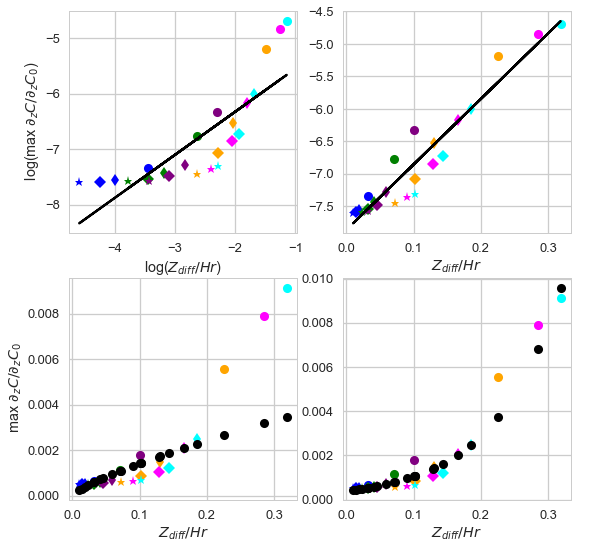

In [13]:
# Max gradient

fig, ax = plt.subplots(2,2, figsize=(9,9))

labels=['5','15','25','50']
colors=['blue','green','purple','orange','magenta','cyan']
markers = ['o','d','D','*','P']

Zdif_vec = np.zeros(4*6) # num of ks and num of epsilons
dCmax = np.zeros(4*6) # num of ks and num of epsilons

ii = 0

time = 6
dt, maxt = 10, 86400*time/10

for kk, col in zip([1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2],colors):
    for eps, lab, mm in zip([5,15,25,50], labels, markers):
        
        kappa = smoothHS(hdepth, eps, Hr, kbg, kk)
        conc = timesteppingKv(rho[0],kappa, dt, dz, maxt)
        dCdz = (conc[1:]-conc[:-1])/dz
        maxdC = np.max(dCdz/dCo)
        Zdif = ((kappa[int(Hr/dz)+1]-kappa[int(Hr/dz)-1])*time*3600*24)**0.5
        
        ax[0,0].plot(np.log(Zdif/Hr), np.log(maxdC), 'o', color=col, marker=mm)
        ax[0,1].plot(Zdif/Hr, np.log(maxdC), 'o', color=col, marker=mm)
        
        ax[1,0].plot(Zdif/Hr, (maxdC), 'o', color=col, marker=mm)
        ax[1,1].plot(Zdif/Hr, (maxdC), 'o', color=col, marker=mm)
        
        Zdif_vec[ii] = Zdif
        dCmax[ii] = maxdC
        ii = ii+1
        
ax[0,0].set_xlabel(r'log($Z_{diff}/Hr$)')
ax[0,0].set_ylabel(r' log(max $\partial_z C/\partial_z C_0$)')
ax[0,1].set_xlabel(r'$Z_{diff}/Hr$')

ax[1,0].set_xlabel(r'$Z_{diff}/Hr$')
ax[1,0].set_ylabel(r' max $\partial_z C/\partial_z C_0$')
ax[1,1].set_xlabel(r'$Z_{diff}/Hr$')

ax[0,1].legend(bbox_to_anchor=(1,1))

m0, b0, r_0, p_0, std_0 = scipy.stats.linregress(np.log(Zdif_vec/Hr), np.log(dCmax))
m2, b2, r_2, p_2, std_2 = scipy.stats.linregress(Zdif_vec/Hr, np.log(dCmax))

print(m0, b0, r_0)
print(m2, b2, r_2)

ax[0,0].plot(np.log(Zdif_vec/Hr),np.log(Zdif_vec/Hr)*m0+ b0, '-k')
ax[0,1].plot(Zdif_vec/Hr,(Zdif_vec/Hr)*m2+ b2, '-k')

ax[1,0].plot((Zdif_vec/Hr),np.exp(b0)*(Zdif_vec/Hr)**m0, 'ok')
ax[1,1].plot(Zdif_vec/Hr,np.exp(b2)*np.exp((Zdif_vec/Hr)*m2), 'ok')

print('max dzC/dzC0 = %0.3e exp (%1.2f Zdiff/Hr)' %(np.exp(b2), m2))

-0.629086224964 -9.80622777041 -0.848900376422
-4.84741644767 -7.57467274349 -0.952075142382
min dzC/dzC0 = 5.133e-04 exp (-4.85 Zdiff/Hr)


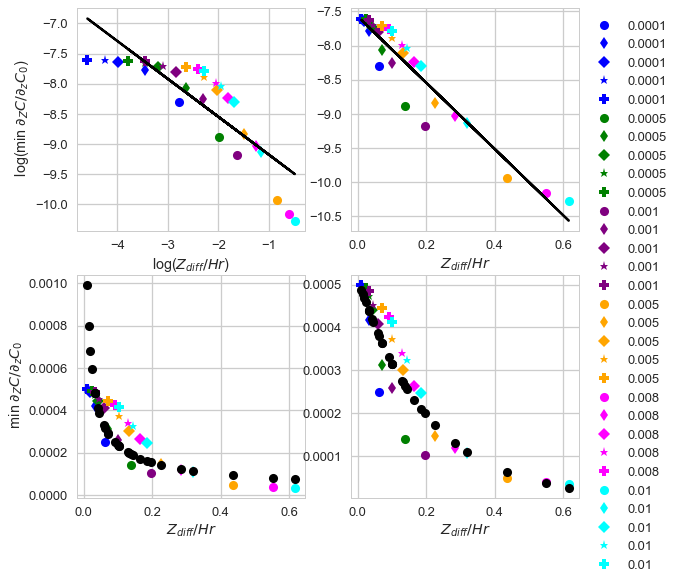

In [14]:
# min dC/dz
fig, ax = plt.subplots(2,2, figsize=(9,9))

labels=['1','5','15','25','50']
colors=['blue','green','purple','orange','magenta','cyan']
markers = ['o','d','D','*','P']

Zdif_vec = np.zeros(5*6) # num of ks and num of epsilons
dCmin = np.zeros(5*6) # num of ks and num of epsilons

ii = 0

time = 6
dt, maxt = 10, 86400*time/10

for kk, col in zip([1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2],colors):
    for eps, lab, mm in zip([1,5,15,25,50], labels, markers):
        
        kappa = smoothHS(hdepth, eps, Hr, kbg, kk)
        conc = timesteppingKv(rho[0],kappa, dt, dz, maxt)
        dCdz = (conc[1:]-conc[:-1])/dz
        mindC = np.min(dCdz/dCo)
        Zdif = ((kappa[int(Hr/dz)+1]-kappa[int(Hr/dz)-1])*time*3600*24)**0.5
        
        ax[0,0].plot(np.log(Zdif/Hr), np.log(mindC), 'o',color=col, label=str(kk), marker=mm)
        ax[0,1].plot(Zdif/Hr, np.log(mindC), 'o',color=col, label=str(kk), marker=mm)
        
        ax[1,0].plot(Zdif/Hr, mindC, 'o',color=col, label=str(kk), marker=mm)
        ax[1,1].plot(Zdif/Hr, mindC, 'o',color=col, label=str(kk), marker=mm)
        
        Zdif_vec[ii] = Zdif
        dCmin[ii] = mindC
        ii = ii+1
        
ax[0,0].set_xlabel(r'log($Z_{diff}/Hr$)')
ax[0,0].set_ylabel(r' log(min $\partial_Z C/\partial_z C_0$)')
ax[0,1].set_xlabel(r'$Z_{diff}/Hr$')

ax[1,0].set_xlabel(r'$Z_{diff}/Hr$')
ax[1,0].set_ylabel(r' min $\partial_Z C/\partial_z C_0$')
ax[1,1].set_xlabel(r'$Z_{diff}/Hr$')

ax[0,1].legend(bbox_to_anchor=(1,1))

m1, b1, r_1, p_1, std_1 = scipy.stats.linregress(np.log(Zdif_vec/Hr), np.log(dCmin))
m3, b3, r_3, p_3, std_3 = scipy.stats.linregress(Zdif_vec/Hr, np.log(dCmin))

print(m1, b1, r_1)
print(m3, b3, r_3)

ax[0,0].plot(np.log(Zdif_vec/Hr),np.log(Zdif_vec/Hr)*m1+ b1, '-k')
ax[0,1].plot(Zdif_vec/Hr,(Zdif_vec/Hr)*m3+ b3, '-k')
ax[1,0].plot((Zdif_vec/Hr),np.exp(b1)*(Zdif_vec/Hr)**m1, 'ok')
ax[1,1].plot(Zdif_vec/Hr,np.exp(b3)*np.exp((Zdif_vec/Hr)*m3), 'ok')

print('min dzC/dzC0 = %0.3e exp (%1.2f Zdiff/Hr)' %(np.exp(b3), m3))

Text(0,0.5,' (min $\\partial_z C/\\partial_z C_0$)')

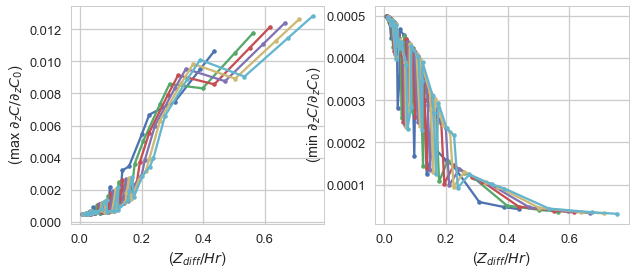

In [15]:

# PLOT RESULTING Derivative
fig, ax = plt.subplots(1,2, figsize=(10,4))

labels=['1','5','15','25','50']
colors=['blue','green','purple','orange','magenta','cyan']
markers = ['o','d','D','*','P']

Zdif_vec = np.zeros(5*6) # num of ks and num of epsilons
dCmax = np.zeros(5*6) # num of ks and num of epsilons
dCmin = np.zeros(5*6) # num of ks and num of epsilons


times = [3,5,6,7,8,9] 

for time,col in zip(times, colors):
    
    ii = 0
    dt, maxt = 10, 86400*time/10

    for kk in [1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2]:
        for eps, lab, mm in zip([1,5,15,25,50], labels, markers):

            kappa = smoothHS(hdepth, eps, Hr, kbg, kk)
            conc = timesteppingKv(rho[0],kappa, dt, dz, maxt)
            dCdz = (conc[1:]-conc[:-1])/dz
            maxdC = np.max(dCdz/dCo)
            mindC = np.min(dCdz/dCo)
            Zdif = ((kappa[int(Hr/dz)+1]-kappa[int(Hr/dz)-1])*time*3600*24)**0.5

            Zdif_vec[ii] = Zdif
            dCmax[ii] = maxdC
            dCmin[ii] = mindC
            ii = ii+1
            orders = np.argsort(Zdif_vec/Hr)
    ax[0].plot((Zdif_vec/Hr)[orders], dCmax[orders], '.-')
    ax[1].plot((Zdif_vec/Hr)[orders], dCmin[orders], '.-')
   
    #m0, b0, r_0, p_0, std_0 = scipy.stats.linregress(np.log(Zdif_vec[:-5]/Hr), np.log(dCmax[:-5]))
    #m1, b1, r_1, p_1, std_1 = scipy.stats.linregress(np.log(Zdif_vec/Hr), np.log(dCmin))
    #m2, b2, r_2, p_2, std_2 = scipy.stats.linregress(Zdif_vec[:-5]/Hr, np.log(dCmax[:-5]))
    #m3, b3, r_3, p_3, std_3 = scipy.stats.linregress(Zdif_vec/Hr, np.log(dCmin))

    #print(m0, b0, r_0)
    #print(m1, b1, r_1)
    #print(m2, b2, r_2)
    #print(m3, b3, r_3)
    #print('-----------------------')

#ax[0,0].plot(np.log(Zdif_vec/Hr),np.log(Zdif_vec/Hr)*m0+ b0, '-k')
#ax[0,1].plot(np.log(Zdif_vec/Hr),np.log(Zdif_vec/Hr)*m1+ b1, '-k')
#ax[1,0].plot(Zdif_vec/Hr,(Zdif_vec/Hr)*m2+ b2, '-k')
#ax[1,1].plot(Zdif_vec/Hr,(Zdif_vec/Hr)*m3+ b3, '-k')

ax[0].set_xlabel(r'($Z_{diff}/Hr$)')
ax[1].set_xlabel(r'($Z_{diff}/Hr$)')
ax[0].set_ylabel(r' (max $\partial_z C/\partial_z C_0$)')
ax[1].set_ylabel(r' (min $\partial_z C/\partial_z C_0$)')


#ax[0,1].legend(bbox_to_anchor=(1,1))



### Figure for Appendix B

min dzC/dzC0 = 1.027e+00 exp (-4.85 Zdiff/Hr)
max dzC/dzC0 = 7.668e-01 exp (10.10 Zdiff/Hr)


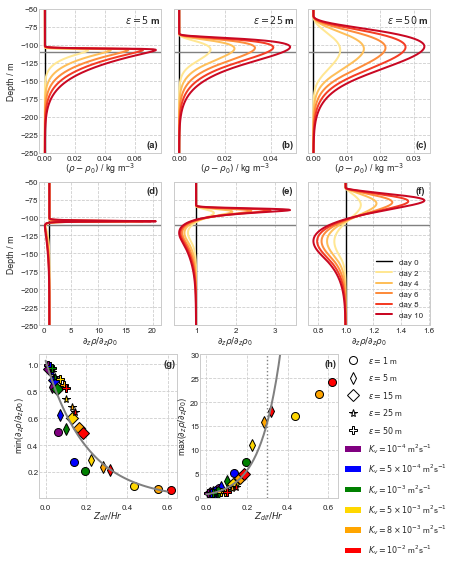

In [25]:
sns.set_context('paper')
sns.set_style('whitegrid',{'grid.linestyle': '--'})

fig = plt.figure(figsize=(7,9))

times = [2,4,6,8,10]

sns.set_palette('YlOrRd',len(times))

gs0 = gspec.GridSpec(3, 1, height_ratios=[1,1,1], hspace=0.2)
gs01 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0],width_ratios=[1,1,1], wspace=0.1)
gs02 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[1],width_ratios=[1,1,1], wspace=0.1)
gs03 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[2],width_ratios=[1,1,0.5], wspace=0.2)
    
ax0 = plt.subplot(gs01[0])
ax1 = plt.subplot(gs01[1])
ax2 = plt.subplot(gs01[2])

ax3 = plt.subplot(gs02[0])
ax4 = plt.subplot(gs02[1])
ax5 = plt.subplot(gs02[2])

ax6 = plt.subplot(gs03[0])
ax7 = plt.subplot(gs03[1])

for axii in [ax1,ax2,ax4,ax5]:
    axii.set_yticklabels([])

for axii in [ax0,ax1,ax2]: 
    l1, = axii.plot(rho[0]-rho[0],-depth,  'k-')
    axii.axhline(-Hr, color='0.5')

for axii in [ax3,ax4,ax5]: 
    dCo = (rho[0,1:]-rho[0,:-1])/dz
    axii.plot(np.squeeze(dCo/dCo),-depth[:-1]-dz/2,  'k-')
    axii.axhline(-Hr, color='0.5')
lines = [l1]


for time in times:
    dt, maxt = 10, 86400*time/10
              
    conc02 = timesteppingKv(rho[0],smoothHS(hdepth, 5, Hr, 1E-5, 1E-2), dt, dz, maxt)
    conc04 = timesteppingKv(rho[0],smoothHS(hdepth, 25, Hr, 1E-5, 1E-2), dt, dz, maxt)
    conc05 = timesteppingKv(rho[0],smoothHS(hdepth, 50, Hr, 1E-5, 1E-2), dt, dz, maxt)
    
    dC2 = (conc02[1:]-conc02[:-1])/dz
    dC4 = (conc04[1:]-conc04[:-1])/dz
    dC5 = (conc05[1:]-conc05[:-1])/dz
    
    ax0.plot(conc02-rho[0],-depth, linewidth=2)
    ax1.plot(conc04-rho[0],-depth, linewidth=2)
    l2, = ax2.plot(conc05-rho[0],-depth, linewidth=2)
    lines.append(l2)

    ax3.plot(dC2/dCo,-depth[:-1]-dz/2, linewidth=2)
    ax4.plot(dC4/dCo,-depth[:-1]-dz/2, linewidth=2)
    ax5.plot(dC5/dCo,-depth[:-1]-dz/2, linewidth=2)
    
ax5.legend((lines), ('day 0', 'day 2', 'day 4', 'day 6', 'day 8', 'day 10'), loc=0) 


ax0.set_ylabel('Depth / m')
ax0.tick_params(axis='y', pad=1)
ax3.set_ylabel('Depth / m')
ax3.tick_params(axis='y', pad=1)

for aa in [ax0,ax1,ax2]:
    aa.set_xlabel(r'$(\rho-\rho_0)$ / kg m$^{-3}$', labelpad=0)
    aa.tick_params(axis='x', pad=2)
    aa.set_ylim(-250,-50)
for aa in [ax3,ax4,ax5]:
    aa.set_xlabel(r'$\partial_z\rho/\partial_z\rho_0$', labelpad=1)
    aa.set_ylim(-250,-50)
    aa.tick_params(axis='x', pad=2)

ax0.text(0.7, 0.9, r'$\epsilon=5$ m',fontweight='bold', transform=ax0.transAxes)
ax1.text(0.65, 0.9, r'$\epsilon=25$ m',fontweight='bold', transform=ax1.transAxes)
ax2.text(0.65, 0.9, r'$\epsilon=50$ m',fontweight='bold', transform=ax2.transAxes)

ax0.text(0.88, 0.04,  '(a)',fontweight='bold', transform=ax0.transAxes)
ax1.text(0.88, 0.04, '(b)',fontweight='bold', transform=ax1.transAxes)
ax2.text(0.88, 0.04, '(c)',fontweight='bold', transform=ax2.transAxes)

ax3.text(0.88, 0.92,  '(d)',fontweight='bold', transform=ax3.transAxes)
ax4.text(0.88, 0.92, '(e)',fontweight='bold', transform=ax4.transAxes)
ax5.text(0.88, 0.92, '(f)',fontweight='bold', transform=ax5.transAxes)

ax6.text(0.9, 0.92, '(g)',fontweight='bold', transform=ax6.transAxes)
ax7.text(0.9, 0.92, '(h)',fontweight='bold', transform=ax7.transAxes)


#---------------- scale min dC/dCo ---------------------------------------------------------------
labels=['1','5','15','25','50']
colors=['purple','blue','green','gold','orange','red']
markers = ['o','d','D','*','P']

Zdif_min = np.zeros(5*6) # num of ks and num of epsilons
dCmin = np.zeros(5*6) # num of ks and num of epsilons

ii = 0
time = 6
dt, maxt = 10, 86400*time/10

for kk, col in zip([1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2],colors):
    for eps, lab, mm in zip([1,5,15,25,50], labels, markers):
        kappa = smoothHS(hdepth, eps, Hr, kbg, kk)
        conc = timesteppingKv(rho[0],kappa, dt, dz, maxt)
        dCdz = (conc[1:]-conc[:-1])/dz
        mindC = np.min(dCdz/dCo)
        Zdif = ((kappa[int(Hr/dz)+1]-kappa[int(Hr/dz)-1])*time*3600*24)**0.5
        
        ax6.plot(Zdif/Hr, mindC, 'o',color=col, label=str(kk), marker=mm, markeredgewidth=1.0,
                 markeredgecolor = 'k', markersize=8)
        
        Zdif_min[ii] = Zdif
        dCmin[ii] = mindC
        ii = ii+1

ax6.set_ylabel(r' min($\partial_z \rho/\partial_z \rho_0$)', labelpad=1)
ax6.set_xlabel(r'$Z_{dif}/Hr$', labelpad=0)


m3, b3, r_3, p_3, std_3 = scipy.stats.linregress(Zdif_min/Hr, np.log(dCmin))

xx = np.linspace(0,0.6,50)
fit = np.exp(b3)*np.exp((xx)*m3)
ax6.plot(xx,fit, '-', color = '0.5', linewidth=2)

ax6.tick_params(axis='y', pad=1)

print('min dzC/dzC0 = %0.3e exp (%1.2f Zdiff/Hr)' %(np.exp(b3), m3))

# -------------------- scale max dC/dCo ---------------------------------------------------

labels=['1','5','15','25','50']
colors=['purple','blue','green','gold','orange','red']
markers = ['o','d','D','*','P']

Zdif_max = np.zeros(4*6) # num of ks and num of epsilons
dCmax = np.zeros(4*6) # num of ks and num of epsilons

ii = 0
time = 6
dt, maxt = 10, 86400*time/10

for kk, col in zip([1E-4, 5E-4, 1E-3, 5E-3, 8E-3, 1E-2],colors):
    for eps, lab, mm in zip([1.,5.,15.,25.,50.], labels, markers):
        
        kappa = smoothHS(hdepth, eps, Hr, kbg, kk)
        conc = timesteppingKv(rho[0],kappa, dt, dz, maxt)
        dCdz = (conc[1:]-conc[:-1])/dz
        maxdC = np.max(dCdz/dCo)
        Zdif = ((kappa[int(Hr/dz)+1]-kappa[int(Hr/dz)-1])*time*3600*24)**0.5
        ax7.plot(Zdif/Hr, (maxdC), 'o', color=col, marker=mm, markeredgewidth=1.0,
                 markeredgecolor = 'k', markersize=8)
        
        if eps <= 1.: # don't use e=1 to fit data because it saturates
            continue
        else:
            Zdif_max[ii] = Zdif
            dCmax[ii] = maxdC
            ii = ii+1

ax7.set_ylabel(r' max($\partial_z \rho/\partial_z \rho_0$)', labelpad = 1)
ax7.set_xlabel(r'$Z_{dif}/Hr$', labelpad=0)

m2, b2, r_2, p_2, std_2 = scipy.stats.linregress(Zdif_max/Hr, np.log(dCmax))

xx = np.linspace(0,0.6,50)
fit = np.exp(b2)*np.exp((xx)*m2)
ax7.plot(xx,fit, '-', color = '0.5', linewidth=2)

ax7.axvline(0.3, color='0.5', linestyle=':')

ax7.set_ylim(0,30)
ax7.tick_params(axis='y', pad=1)

print('max dzC/dzC0 = %0.3e exp (%1.2f Zdiff/Hr)' %(np.exp(b2), m2))


legend_elements = [Line2D([0], [0], marker='o', color='w',markeredgecolor='k',markeredgewidth=1.0,
                          label='$\epsilon= 1$ m',markerfacecolor='w', markersize=8),
                   Line2D([0], [0], marker='d', color='w',markeredgecolor='k',markeredgewidth=1.0,
                          label='$\epsilon= 5$ m',markerfacecolor='w', markersize=8),
                   Line2D([0], [0], marker='D', color='w',markeredgecolor='k',markeredgewidth=1.0, 
                          label='$\epsilon= 15$ m',markerfacecolor='w', markersize=8),
                   Line2D([0], [0], marker='*', color='w',markeredgecolor='k',markeredgewidth=1.0, 
                          label='$\epsilon= 25$ m',markerfacecolor='w', markersize=8),
                   Line2D([0], [0], marker='P', color='w',markeredgecolor='k',markeredgewidth=1.0,
                          label='$\epsilon= 50$ m',markerfacecolor='w', markersize=8),
                   Patch(facecolor='purple', label=r'$K_v=10^{-4}$ m$^2$s$^{-1}$'),
                   Patch(facecolor='blue', label=r'$K_v=5\times10^{-4}$ m$^2$s$^{-1}$'),
                   Patch(facecolor='green', label=r'$K_v=10^{-3}$ m$^2$s$^{-1}$'),
                   Patch(facecolor='gold', label=r'$K_v=5\times10^{-3}$ m$^2$s$^{-1}$'),
                   Patch(facecolor='orange', label=r'$K_v=8\times10^{-3}$ m$^2$s$^{-1}$'),
                   Patch(facecolor='red', label=r'$K_v=10^{-2}$ m$^2$s$^{-1}$'),
                  ]


ax7.legend(handles=legend_elements, bbox_to_anchor=(1,1.05),labelspacing=0.8)
plt.savefig('figure_1Dmodel.eps', format='eps',bbox_inches='tight')

In [ ]:
Zdif_max

In [ ]:
conc01

In [ ]:
maxt = (3600*24*numdias)/dt